In [1]:
# Install seaborn if not already installed
import sys

In [2]:
import pandas as pd
import numpy as np

## Experiment 1

In [3]:
import glob
import os

# 1. Dateien identifizieren (Ihre Logik)
jsonl_files = [f for f in glob.glob("results_vllm/*.jsonl") if 'n1' not in f and 'n5' not in f]

# 2. Daten laden & Mergen
dfs = []
for file in jsonl_files:
    # lines=True ist entscheidend für JSONL
    try:
        temp_df = pd.read_json(file, lines=True)
        # Optional: Modellname aus Dateiname extrahieren, falls nicht im JSON
        # temp_df['model_filename'] = os.path.basename(file) 
        dfs.append(temp_df)
    except ValueError as e:
        print(f"Fehler beim Lesen von {file}: {e}")

if not dfs:
    raise ValueError("Keine Dateien gefunden! Pfad prüfen.")

df = pd.concat(dfs, ignore_index=True)

In [4]:
# 3. Preprocessing (Angepasst auf task_id)
# Logik: "1998_3und4_A1" -> split('_') -> ["1998", "3und4", "A1"] -> letztes Elem. "A1" -> erstes Zeichen "A"
df['difficulty'] = df['task_id'].apply(lambda x: str(x).split('_')[-1][0].upper())

# Score numerisch machen
df['score'] = df['is_correct'].astype(int)

# 4. Aggregation

# A) Gesamt Accuracy
acc_total = df.groupby('model')['score'].mean().to_frame(name='Acc')

# B) Modalität (Text vs. Visuell)
# False = Visuell notwendig, True = Text-only
acc_modal = df.groupby(['model', 'is_text_only'])['score'].mean().unstack()
acc_modal.columns = ['Visuell', 'Text-only'] 

# C) Schwierigkeit (Level A, B, C)
acc_diff = df.groupby(['model', 'difficulty'])['score'].mean().unstack()
acc_diff.columns = [f"Level {c}" for c in acc_diff.columns]

# D) Mathe-Kategorie
acc_cat = df.groupby(['model', 'math_category'])['score'].mean().unstack()

# 5. Zusammenfügen & Hierarchie
result = pd.concat([acc_total, acc_modal, acc_diff, acc_cat], axis=1)

# MultiIndex Spalten erstellen
multi_cols = []
for col in result.columns:
    if col == 'Acc':
        multi_cols.append(('Gesamt', 'Acc'))
    elif col in ['Text-only', 'Visuell']:
        multi_cols.append(('Modalität', col))
    elif 'Level' in col:
        multi_cols.append(('Schwierigkeit', col))
    else:
        multi_cols.append(('Kategorie', col))

result.columns = pd.MultiIndex.from_tuples(multi_cols)

# 6. Darstellung
result = result.sort_values(('Gesamt', 'Acc'), ascending=False)

In [5]:
result.to_csv("evaluation_summary_ex1.csv")

/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_64735/214744063.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_score = text_scores[i]
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_64735/214744063.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v_score = vis_scores[i]


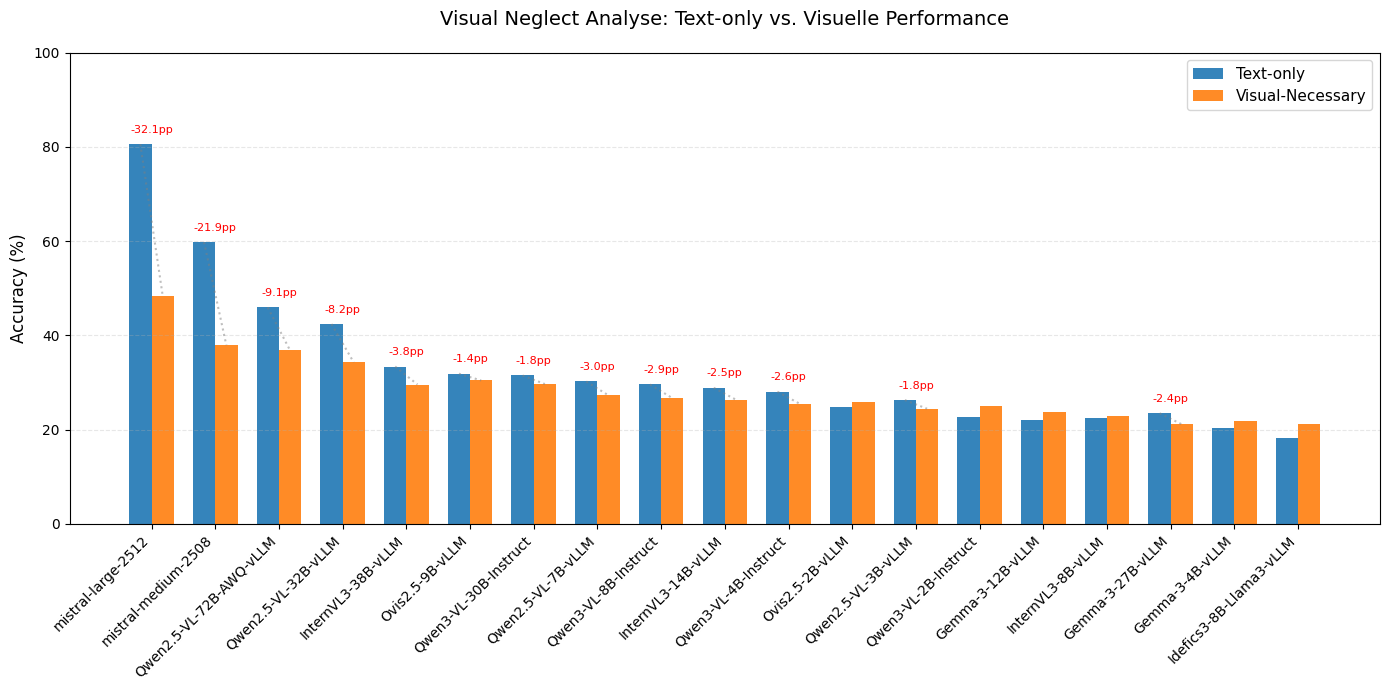

In [8]:

# Wir nutzen die Aggregation aus dem vorherigen Schritt
plot_data = result['Modalität'][['Text-only', 'Visuell']].copy()

# Optional: Sortieren nach dem "Visual Gap" (Text - Visuell), um den Effekt zu verdeutlichen
# plot_data['Gap'] = plot_data['Text-only'] - plot_data['Visuell']
# plot_data = plot_data.sort_values('Gap', ascending=False)
# Oder: Sortieren nach Modell-Familie (wie in der Tabelle) - wir lassen es hier wie in 'result' sortiert.

models = plot_data.index
text_scores = plot_data['Text-only'] * 100  # In Prozent
vis_scores = plot_data['Visuell'] * 100     # In Prozent

# 2. Plot-Setup
x = np.arange(len(models))  # Label Positionen
width = 0.35                # Breite der Balken

fig, ax = plt.subplots(figsize=(14, 7))

# Balken zeichnen
rects1 = ax.bar(x - width/2, text_scores, width, label='Text-only', color='#1f77b4', alpha=0.9)
rects2 = ax.bar(x + width/2, vis_scores, width, label='Visual-Necessary', color='#ff7f0e', alpha=0.9)

# 3. Styling & Labels
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Visual Neglect Analyse: Text-only vs. Visuelle Performance', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 4. "Insight"-Highlight: Gap Visualisierung (Optional)
# Zeichnet kleine Linien zwischen den Balken, um den Abstand zu zeigen
for i in range(len(models)):
    t_score = text_scores[i]
    v_score = vis_scores[i]
    
    # Nur zeichnen, wenn Text besser als Visuell (der Regelfall beim Visual Neglect)
    if t_score > v_score:
        # Linie zwischen den Balkenoberkanten
        ax.plot([x[i] - width/2, x[i] + width/2], [t_score, v_score], color='gray', linestyle=':', alpha=0.5)
        # Text für das Delta
        delta = t_score - v_score
        ax.text(x[i], max(t_score, v_score) + 2, f'-{delta:.1f}pp', 
                ha='center', va='bottom', fontsize=8, color='red', rotation=0)

plt.tight_layout()
plt.show()

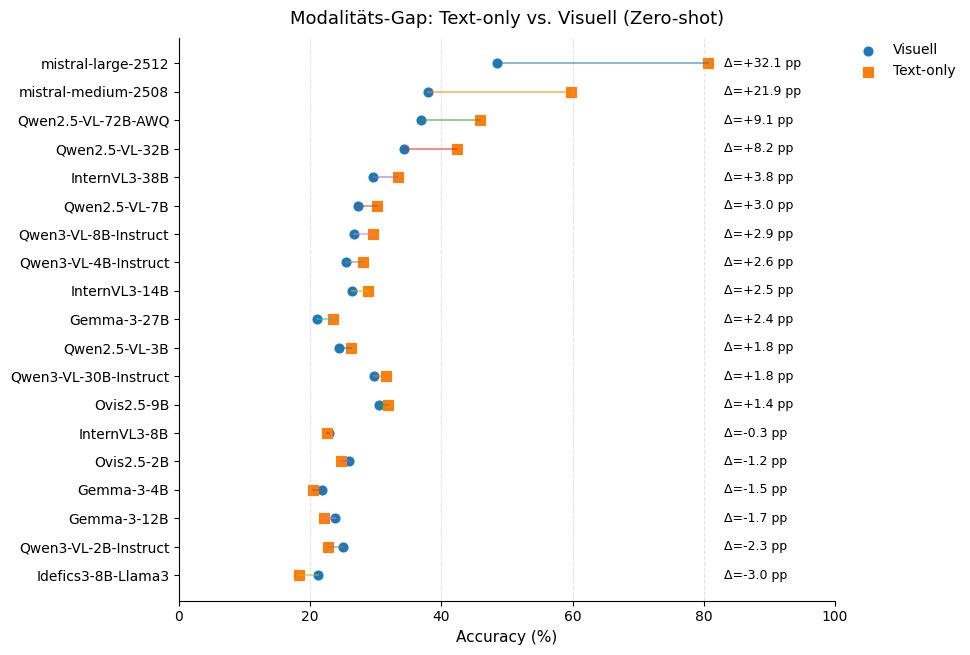

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_modality_gap_dumbbell(plot_data, sort_by_gap=True, title=None, savepath=None):
    """
    plot_data: DataFrame, index = Modelle, Spalten = ['Text-only', 'Visuell']
              Werte entweder in [0,1] oder bereits in Prozent.
    """
    df = plot_data[['Text-only', 'Visuell']].copy()

    # robust: automatisch auf Prozent skalieren, falls Werte in [0,1]
    if df.max().max() <= 1.0:
        df = df * 100.0

    df['Gap_pp'] = df['Text-only'] - df['Visuell']  # Prozentpunkte

    if sort_by_gap:
        df = df.sort_values('Gap_pp', ascending=False)

    # ggf. Suffixe entfernen (wie bei dir)
    models = [m.replace('-vLLM', '') for m in df.index.to_list()]
    y = np.arange(len(models))

    text = df['Text-only'].to_numpy()
    vis  = df['Visuell'].to_numpy()
    gap  = df['Gap_pp'].to_numpy()

    fig, ax = plt.subplots(figsize=(10.5, max(4.5, 0.35 * len(models))))

    # Verbindungssegmente (Dumbbells)
    for i in range(len(models)):
        ax.plot([vis[i], text[i]], [y[i], y[i]], linewidth=1.2, alpha=0.6)

    # Punkte (Markerformen -> auch ohne Farbe unterscheidbar)
    ax.scatter(vis,  y, s=42, marker='o', linewidths=0.8, label='Visuell')
    ax.scatter(text, y, s=42, marker='s', linewidths=0.8, label='Text-only')

    # Δ-Annotation rechts neben den Segmenten
    x_max = float(max(df['Text-only'].max(), df['Visuell'].max()))
    pad = 2.5
    for i in range(len(models)):
        ax.text(x_max + pad, y[i], f"Δ={gap[i]:+,.1f} pp",
                va='center', ha='left', fontsize=9)

    # Achsen & Layout
    ax.set_yticks(y)
    ax.set_yticklabels(models, fontsize=10)
    ax.invert_yaxis()

    ax.set_xlabel('Accuracy (%)', fontsize=11)
    if title is None:
        title = 'Modalitäts-Gap: Text-only vs. Visuell (Zero-shot)'
    ax.set_title(title, fontsize=13, pad=10)

    # Skala + Grid
    ax.set_xlim(0, min(100, x_max + pad + 18))  # extra Platz rechts
    ax.grid(axis='x', linestyle='--', linewidth=0.8, alpha=0.35)

    # „Paper look“: Spines reduzieren
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legende außerhalb (rechts oben) -> kein Overlap mit Δ
    ax.legend(
        frameon=False,
        fontsize=10,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0
    )

    # Layout so, dass rechts Platz bleibt (Legende + Δ nicht abgeschnitten)
    fig.tight_layout()
    fig.subplots_adjust(right=0.80)

    if savepath:
        fig.savefig(savepath, bbox_inches='tight')  # z.B. "modality_gap.pdf"

    plt.show()


# Verwendung:
plot_data = result['Modalität'][['Text-only', 'Visuell']].copy()
plot_modality_gap_dumbbell(plot_data, sort_by_gap=True, savepath="modality_gap.pdf")


In [ ]:
from math import pi
categories_df = result['Kategorie'][['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik', "unknown"]].copy()

In [ ]:
categories_df

,Arithmetik,Algebra,Geometrie,Stochastik,unknown
model,,,,,
mistral-large-2512,0.777076,0.755481,0.436644,0.618887,0.461538
mistral-medium-2508,0.599639,0.554806,0.355613,0.424958,0.329670
Qwen2.5-VL-72B-AWQ-vLLM,0.451758,0.428331,0.350171,0.433390,0.340659
Qwen2.5-VL-32B-vLLM,0.399459,0.396290,0.342466,0.387858,0.428571
InternVL3-38B-vLLM,0.311993,0.317032,0.291096,0.350759,0.329670
Ovis2.5-9B-vLLM,0.308386,0.330523,0.294521,0.320405,0.362637
Qwen3-VL-30B-Instruct,0.305681,0.301855,0.304795,0.300169,0.351648
Qwen2.5-VL-7B-vLLM,0.286745,0.290051,0.269692,0.315346,0.252747
Qwen3-VL-8B-Instruct,0.267809,0.311973,0.273973,0.290051,0.230769


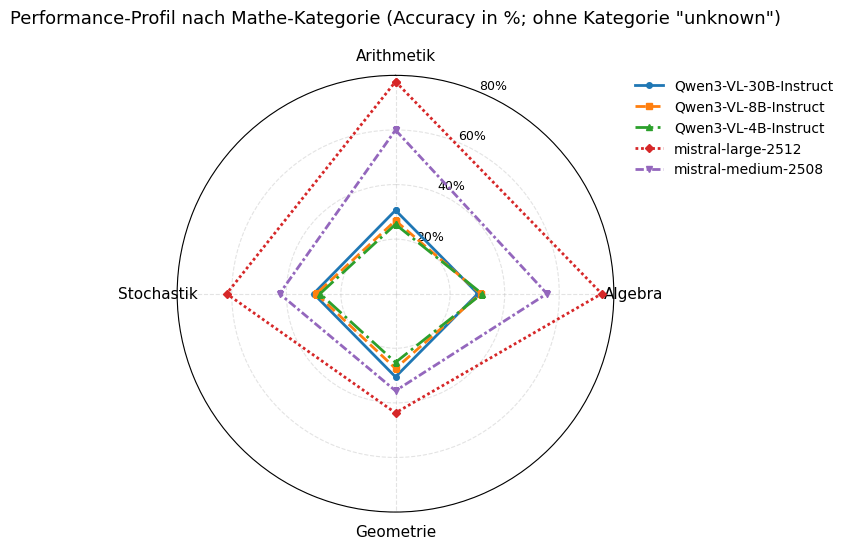

In [9]:
from math import pi
categories_df = result['Kategorie'][['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']].copy()

# robust: falls Werte in [0,1], auf Prozent skalieren
if categories_df.max().max() <= 1.0:
    categories_df = categories_df * 100.0

selection = [
    'Qwen3-VL-30B-Instruct', 'Qwen3-VL-8B-Instruct', 'Qwen3-VL-4B-Instruct',
    'mistral-large-2512', 'mistral-medium-2508',
]

plot_df = categories_df.loc[[m for m in selection if m in categories_df.index]]
# Attribute (Kategorien)
categories = list(plot_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)

# Dynamische r-Skala (auf Daten abgestimmt, "paper-like" ticks)
r_max = float(np.ceil(plot_df.to_numpy().max() / 10) * 10)  # z.B. auf 10er runden
ticks = np.linspace(0, r_max, 5)[1:]  # 4 ticks ohne 0
ax.set_yticks(ticks)
ax.set_yticklabels([f"{int(t)}%" for t in ticks], fontsize=9)
ax.set_ylim(0, r_max)

# dezentes Grid
ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.35)

linestyles = ['solid', 'dashed', 'dashdot', (0, (1, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, (name, row) in enumerate(plot_df.iterrows()):
    vals = row.to_list()
    vals += vals[:1]
    ax.plot(
        angles, vals,
        linewidth=2.0,
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        markersize=4,
        label=name
    )
    # Füllung sparsam oder weglassen (Paper-typisch eher weglassen)
    # ax.fill(angles, vals, alpha=0.06)

ax.legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1.02))
ax.set_title("Performance-Profil nach Mathe-Kategorie (Accuracy in %; ohne Kategorie \"unknown\")", fontsize=13, pad=18)

plt.tight_layout()
plt.show()

In [10]:
# df: Zeile = Aufgabe, mit Spalten: model, math_category, is_text_only, is_correct
cats = ['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']
sel = ['Qwen3-VL-30B-Instruct','Qwen3-VL-8B-Instruct','Qwen3-VL-4B-Instruct','mistral-large-2512','mistral-medium-2508']

dff = df[df['math_category'].isin(cats) & df['model'].isin(sel)].copy()

def _pivot(modality_bool):
    tmp = dff[dff['is_text_only'] == modality_bool]
    out = (tmp.groupby(['model','math_category'])['is_correct'].mean()
              .unstack('math_category')
              .reindex(sel))
    return out * 100.0

plot_df_text = _pivot(True)[cats]
plot_df_vis  = _pivot(False)[cats]

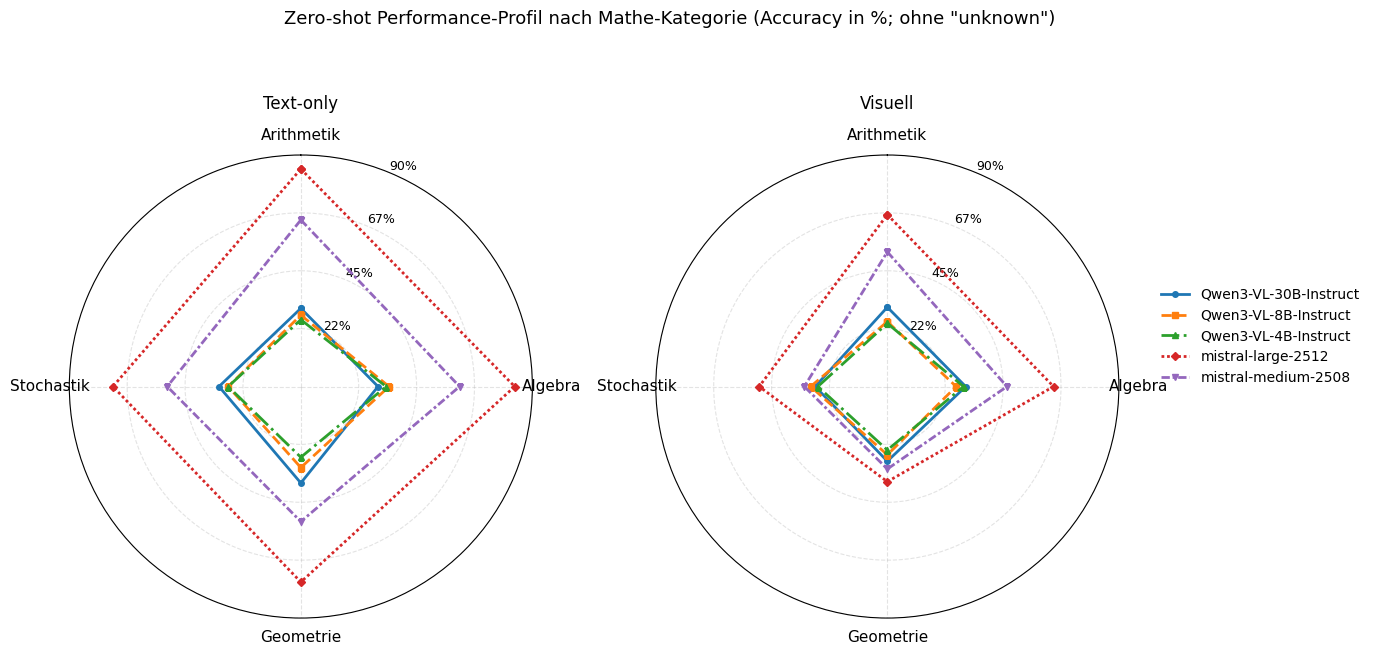

In [11]:
def _radar_panel(ax, plot_df, title, r_max, angles, categories,
                 linestyles, markers):
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)

    ticks = np.linspace(0, r_max, 5)[1:]  # 4 ticks ohne 0
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{int(t)}%" for t in ticks], fontsize=9)
    ax.set_ylim(0, r_max)

    ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.35)
    ax.set_title(title, fontsize=12, pad=14)

    handles = []
    labels = []
    for i, (name, row) in enumerate(plot_df.iterrows()):
        vals = row.to_list()
        vals += vals[:1]
        h = ax.plot(
            angles, vals,
            linewidth=2.0,
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=4,
            label=name
        )[0]
        handles.append(h)
        labels.append(name)
    return handles, labels


# -----------------------------
# Voraussetzung: zwei DF bauen
# plot_df_text: Accuracy% nach Kategorie nur Text-only
# plot_df_vis : Accuracy% nach Kategorie nur Visuell
# -----------------------------

# Kategorien (Spalten)
categories = ['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

linestyles = ['solid', 'dashed', 'dashdot', (0, (1, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v', 'P']

# Gemeinsame Skala (sehr wichtig)
global_max = max(plot_df_text.to_numpy().max(), plot_df_vis.to_numpy().max())
r_max = float(np.ceil(global_max / 10) * 10)

fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.8), subplot_kw=dict(polar=True))

h1, lab1 = _radar_panel(axes[0], plot_df_text, "Text-only", r_max, angles, categories, linestyles, markers)
h2, lab2 = _radar_panel(axes[1], plot_df_vis,  "Visuell",   r_max, angles, categories, linestyles, markers)

# Eine gemeinsame Legende (reduziert visuelles Rauschen)
fig.legend(h1, lab1, frameon=False, fontsize=10, loc='center right', bbox_to_anchor=(1.02, 0.5))

fig.suptitle('Zero-shot Performance-Profil nach Mathe-Kategorie (Accuracy in %; ohne "unknown")', fontsize=13, y=0.98)
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.show()


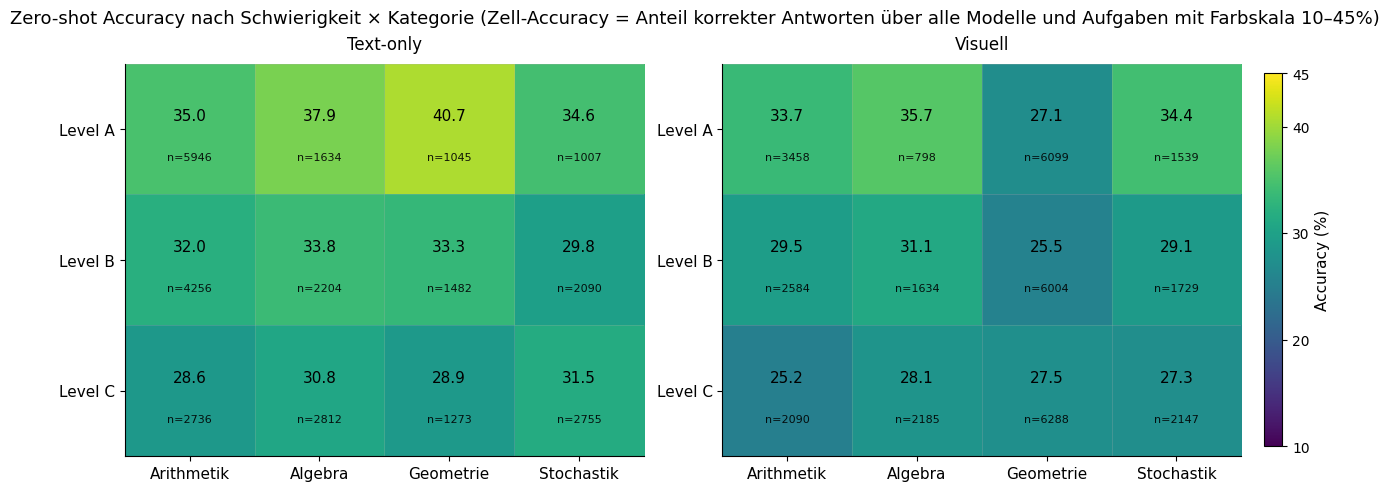

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CATS   = ["Arithmetik", "Algebra", "Geometrie", "Stochastik"]
LEVELS = ["A", "B", "C"]  # falls bei dir "Level A" etc. steht: hier anpassen

def variantA_cell_acc(df, cats=CATS, levels=LEVELS, text_only=None):
    """
    Variante A (pooled): Accuracy je (difficulty, category) über alle Modelle+Tasks.
    text_only: True (Text-only), False (Visuell), None (beides zusammen)
    Returns:
      acc: DataFrame (levels x cats) in Prozent
      n  : DataFrame (levels x cats) counts
    """
    d = df.copy()
    d = d[d["math_category"].isin(cats)]
    d = d[d["difficulty"].isin(levels)]

    if text_only is not None:
        d = d[d["is_text_only"] == bool(text_only)]

    g = d.groupby(["difficulty", "math_category"])["is_correct"]
    acc = (g.mean() * 100).unstack("math_category").reindex(index=levels, columns=cats)
    n   = g.size().unstack("math_category").reindex(index=levels, columns=cats)

    return acc, n


def plot_two_heatmaps(acc_left, n_left, acc_right, n_right,
                      title_left="Text-only", title_right="Visuell",
                      suptitle="Accuracy nach Schwierigkeit × Kategorie (Variante A, pooled)",
                      vmin=10.0, vmax=45.0,
                      savepath=None):
    """
    Zwei Heatmaps nebeneinander mit identischer (trunkierter) Skala, inkl. Zell-Annotation (Acc + n).
    vmin/vmax: hier bewusst 10–45, um Kontraste im relevanten Bereich sichtbar zu machen.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8), constrained_layout=True)

    def _panel(ax, acc, n, title):
        im = ax.imshow(acc.to_numpy(), vmin=vmin, vmax=vmax, aspect="auto")

        ax.set_title(title, fontsize=12, pad=10)

        ax.set_xticks(np.arange(acc.shape[1]))
        ax.set_xticklabels(acc.columns, fontsize=11)
        ax.set_yticks(np.arange(acc.shape[0]))
        ax.set_yticklabels([f"Level {x}" for x in acc.index], fontsize=11)

        # dezentes Zellgitter (paper-like)
        ax.set_xticks(np.arange(-0.5, acc.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, acc.shape[0], 1), minor=True)
        ax.grid(which="minor", linestyle="-", linewidth=0.7, alpha=0.25)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Annotation: Accuracy + n; fehlende Zellen (NaN) überspringen
        for i in range(acc.shape[0]):
            for j in range(acc.shape[1]):
                val = acc.iat[i, j]
                cnt = n.iat[i, j]
                if pd.isna(val) or pd.isna(cnt):
                    continue

                ax.text(j, i - 0.10, f"{val:.1f}", ha="center", va="center", fontsize=11)
                ax.text(j, i + 0.22, f"n={int(cnt)}", ha="center", va="center", fontsize=8, alpha=0.9)

        # Spines reduzieren (cleaner Look)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        return im

    im0 = _panel(axes[0], acc_left,  n_left,  title_left)
    im1 = _panel(axes[1], acc_right, n_right, title_right)

    # gemeinsame Colorbar
    cbar = fig.colorbar(im1, ax=axes, shrink=0.95, pad=0.02)
    cbar.set_label("Accuracy (%)", fontsize=11)
    cbar.set_ticks([10, 20, 30, 40, 45])

    fig.suptitle(suptitle, fontsize=13)

    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()


# -----------------------------
# Anwendung
# -----------------------------
# df: Raw-DF mit Spalten:
#   ['model','math_category','difficulty','is_text_only','is_correct', ...]
# Wichtig: 'unknown' vorher ggf. schon als math_category ausgeschlossen oder via CATS nicht enthalten.

acc_text, n_text = variantA_cell_acc(df, text_only=True)
acc_vis,  n_vis  = variantA_cell_acc(df, text_only=False)

plot_two_heatmaps(
    acc_text, n_text,
    acc_vis,  n_vis,
    title_left="Text-only",
    title_right="Visuell",
    suptitle='Zero-shot Accuracy nach Schwierigkeit × Kategorie (Zell-Accuracy = Anteil korrekter Antworten über alle Modelle und Aufgaben mit Farbskala 10–45%)',
    vmin=10.0, vmax=45.0,
    savepath="heatmap_difficulty_x_category_text_vs_vis_10_45.pdf"
)
